In [1]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math
import json
import inspect
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from mpl_toolkits import mplot3d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [3]:
cur_dir = './drive/My Drive/Copy/'
data = pd.read_hdf(cur_dir + 'output_files/strack_events.h5', '/RECO/Events')

In [4]:
x_all, y_all, z_all = [], [], []
for event in data.event.unique():
    my_event = data[data.event == event]
    image_3d = np.stack((my_event.X, my_event.Y, my_event.Z), axis=1)
    db = DBSCAN(eps=20, min_samples=30).fit(image_3d)
    clusters = np.array(db.fit_predict(image_3d))
    indices = np.array([i for i, x in enumerate(clusters) if x == 0])
    X_ = np.array(my_event.X)[indices]
    Y_ = np.array(my_event.Y)[indices]
    Z_ = np.array(my_event.Z)[indices]
    x_all.append(max(X_) - min(X_))
    y_all.append(max(Y_) - min(Y_))
    z_all.append(max(Z_) - min(Z_))
x_range, y_range, z_range = max(x_all), max(y_all), math.ceil(max(z_all))

In [5]:
X_shape = int(x_range/10) + 2
Y_shape = int(y_range/10) + 1
print(X_shape, Y_shape)

30 30


In [6]:
def coord_to_image(X, Y, E):
    image = np.zeros((X_shape, Y_shape))
    for i in range(len(X)):
        if (X[i]%10 == 0) and (Y[i]%10 == 0):
            image[int(Y[i]/10)][int(X[i]/10)] = E[i]
    return image

def coord_to_image_plain(X, Y, E):
    image = np.zeros((X_shape, Y_shape))
    for i in range(len(X)):
        image[int(Y[i])][int(X[i])] = E[i]
    return image

def image_to_coord(image):
    Z = np.nonzero(image)[0]
    Y = np.nonzero(image)[1]
    X = np.nonzero(image)[2]
    E = image[np.where(image!=0)]
    return X, Y, Z, E

class Transform(object):
    def __init__(self, image):
        """init"""
        self.image = image
        return None
    def no_change(self):
        X, Y, Z, E = image_to_coord(self.image)
        Z = Z - min(Z)
        fig = plt.figure()
        return X, Y, Z, E
    def flip_z(self):
        """flip_z"""
        z_image = np.flip(self.image, 0)
        X, Y, Z, E = image_to_coord(z_image)
        Z = Z - min(Z)
        return X, Y, Z, E
    def flip_y(self):
        y_image = np.flip(self.image, 1)
        X, Y, Z, E = image_to_coord(y_image)
        Y = Y - min(Y)
        return X, Y, Z, E
    def flip_x(self):
        x_image = np.flip(self.image, 2)
        X, Y, Z, E = image_to_coord(x_image)
        X = X - min(X)
        return X, Y, Z, E

def convert_to_3D(X_, Y_, Z_, E_, z_step):
    my_event = pd.DataFrame({'X' : X_, 'Y' : Y_, 'Z' : Z_, 'E' : E_})
    Z = my_event.Z
    event_image = []
    for z in range(math.floor(min(Z)), math.floor(min(Z)) + z_range + z_step, z_step):
        z_slice = Z[(Z >= z) & (Z < z+z_step)]
        z_slice = z_slice.unique()
        num_z_slices = len(z_slice)
        if num_z_slices == 0:
            X = [0, 0]
            Y = [0, 0]
            E = [0, 0]
            image_x_y = coord_to_image(X, Y, E)
        else:
            z_count = 0
            for each_z in z_slice:
                event_slice = my_event[my_event.Z == each_z]
                X = list(event_slice.X)
                Y = list(event_slice.Y)
                E = list(event_slice.E)
                if z_count == 0:
                    image_x_y = coord_to_image(X, Y, E)
                    z_count += 1
                else:
                    image_x_y += coord_to_image(X, Y, E)
        event_image.append(image_x_y)
    return np.array(event_image), image_x_y.shape[0], image_x_y.shape[1]

def convert_to_3D_plain(X_, Y_, Z_, E_, N):
    my_event = pd.DataFrame({'X' : X_, 'Y' : Y_, 'Z' : Z_, 'E' : E_})
    event_image = []
    for z in range(math.floor(min(Z_)), max(Z_)):
        X = list(my_event[my_event.Z == z].X)
        Y = list(my_event[my_event.Z == z].Y)
        E = list(my_event[my_event.Z == z].E)
        image_x_y = coord_to_image_plain(X, Y, E)
        event_image.append(image_x_y)
    for z in range(N - (max(Z_) - min(Z_))):
        X = [0, 0]
        Y = [0, 0]
        E = [0, 0]
        image_x_y = coord_to_image(X, Y, E)
        event_image.append(image_x_y)
    return np.array(event_image)

In [7]:
def process_data(data, z_step, counter_start=0, counter_end=len(data.event.unique())):
    train_data = []
    train_output = []
    counter = counter_start
    for event in data.event.unique()[counter_start:counter_end]:
        print("Onto #" + str(counter))
        my_event = data[data.event == event]
        image_3d = np.stack((my_event.X, my_event.Y, my_event.Z), axis=1)
        db = DBSCAN(eps=20, min_samples=30).fit(image_3d)
        clusters = np.array(db.fit_predict(image_3d))
        indices = np.array([i for i, x in enumerate(clusters) if x == 0])
        X_ = np.array(my_event.X)[indices] - min(np.array(my_event.X)[indices])
        Y_ = np.array(my_event.Y)[indices] - min(np.array(my_event.Y)[indices])
        Z_ = np.array(my_event.Z)[indices] - min(np.array(my_event.Z)[indices])
        E_ = np.array(my_event.E)[indices]
        event_image, im_x_y_x, im_x_y_y = convert_to_3D(X_, Y_, Z_, E_,z_step)
        T = Transform(event_image)
        attrs = (getattr(T, name) for name in dir(T))
        methods = filter(inspect.ismethod, attrs)
        for method in methods:
            try:
                if method.__doc__ != "init":
                    try:
                        X, Y, Z, E = method()
                    except:
                        fig = plt.figure()
                        ax = fig.add_subplot(111, projection='3d')
                        ax.scatter(X, Y, Z)
                    test_image = convert_to_3D_plain(X, Y, Z, E, event_image.shape[0])
                    test_image = np.reshape(test_image, -1)
                    train_data.append(test_image)
                    # this line ensures that the Z coordinate the network is trained on is of the uncropped event
                    # so it gets the true Z position
                    my_event = data[data.event == event]
                    if method.__doc__ == "flip_z":
                        centroid = (max(my_event.Z) - my_event.Z + min(my_event.Z)).mean()
                    else:
                        centroid = my_event.Z.mean()
                    train_output.append([centroid])
                    counter += 1
            except TypeError:
            # cannot handle methods that require arguments...yet!!
                pass
    return np.array(train_data), np.array(train_output)

In [9]:
num_samples = len(data.event.unique())
print(num_samples)
train_data, train_output = process_data(data, 2, 0, 2)

3841
Onto #0
Onto #4


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
para = json.load(open(cur_dir +  "/config.json"))
val_split = 1 - para['train_test_split']
num_epochs = para['epochs']
n_cols = train_data.shape[0]
print(n_cols)
model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(n_cols, )))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

In [ ]:
history = model.fit(train_data, train_output, batch_size=32, validation_split=0.3, epochs=1000, shuffle=True)

ValueError: ignored

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
predict_data, output, predict_x, predict_y = [], [], [], []
for event in range(0, len(train_data), 1):
    predict_data.append(train_data[event])
    output.append(train_output[event])
    predict_x.append(train_x[event])
    predict_y.append(train_y[event])

In [ ]:
predict_output = model.predict(np.array(predict_data))
difference = abs(predict_output - output)

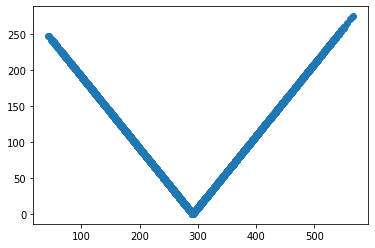

In [ ]:
plt.scatter(output, difference)

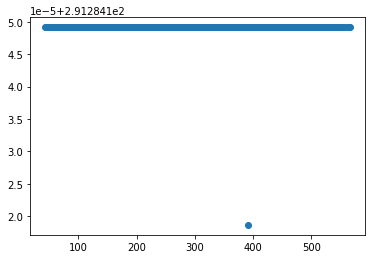

In [ ]:
plt.scatter(output, predict_output)

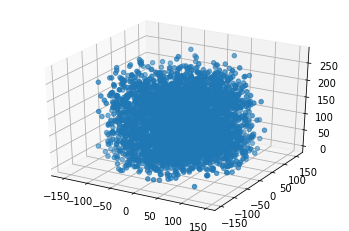

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(predict_x, predict_y, difference)